In [2]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [3]:
#checking for device
device=torch.device('cuda')
print(device)

cuda


In [4]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [6]:
#Dataloader
train_path= r"C:\Users\caren\OneDrive\Documents\Spittinginpublic\train"
test_path= r"C:\Users\caren\OneDrive\Documents\Spittinginpublic\test"
train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=64, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True
)

In [7]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [8]:
print(classes)

['Not spitting', 'Spitting']


In [9]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)
        
         
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)
        
        
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        
        
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
            #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,32*75*75)
            
            
        output=self.fc(output)
            
        return output   
            

In [10]:
model=ConvNet(num_classes=2).to(device)

In [11]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [12]:
num_epochs=10

In [13]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [14]:
print(train_count,test_count)

44 30


In [15]:
#Model training and saving best model

best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpointmodel.pth')
        best_accuracy=test_accuracy
    

Epoch: 0 Train Loss: tensor(0.4900) Train Accuracy: 0.8863636363636364 Test Accuracy: 0.5
Epoch: 1 Train Loss: tensor(13.4599) Train Accuracy: 0.9090909090909091 Test Accuracy: 0.5
Epoch: 2 Train Loss: tensor(16.0396) Train Accuracy: 0.9090909090909091 Test Accuracy: 0.5
Epoch: 3 Train Loss: tensor(12.2455) Train Accuracy: 0.9090909090909091 Test Accuracy: 0.5
Epoch: 4 Train Loss: tensor(7.7569) Train Accuracy: 0.9090909090909091 Test Accuracy: 0.5
Epoch: 5 Train Loss: tensor(4.4364) Train Accuracy: 0.9090909090909091 Test Accuracy: 0.5
Epoch: 6 Train Loss: tensor(0.8207) Train Accuracy: 0.9090909090909091 Test Accuracy: 0.5
Epoch: 7 Train Loss: tensor(1.2463e-07) Train Accuracy: 1.0 Test Accuracy: 0.4666666666666667
Epoch: 8 Train Loss: tensor(0.5767) Train Accuracy: 0.8863636363636364 Test Accuracy: 0.6
Epoch: 9 Train Loss: tensor(3.8311) Train Accuracy: 0.6818181818181818 Test Accuracy: 0.6333333333333333


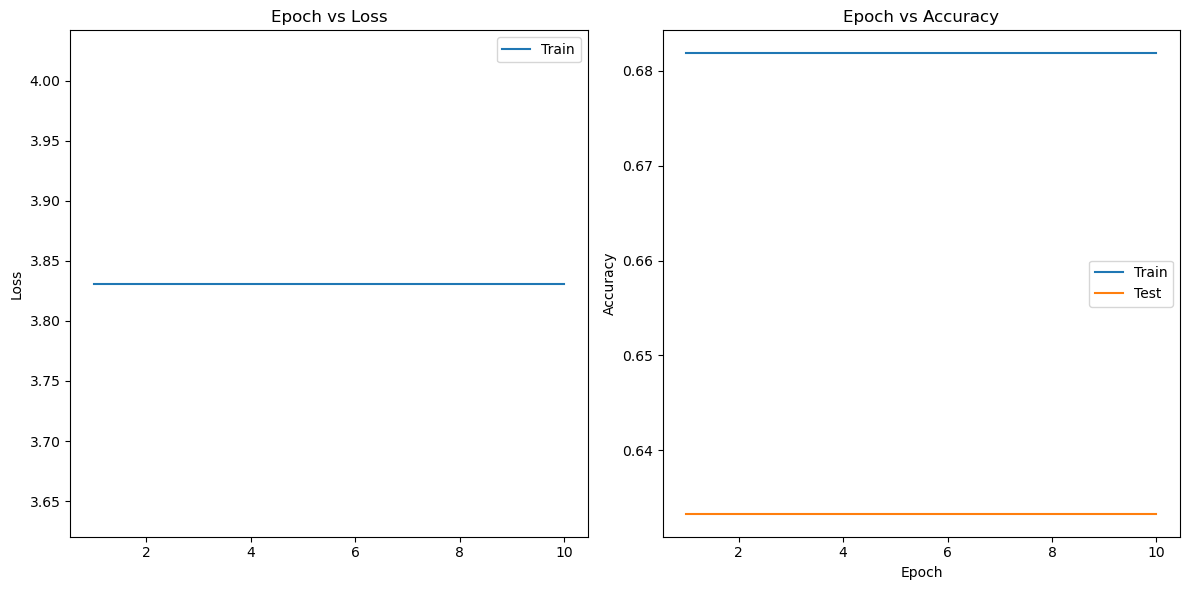

In [16]:
import matplotlib.pyplot as plt

# Lists to store data for plotting
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    # Your training and testing code here...
    # Make sure you calculate train_loss, test_loss, train_accuracy, and test_accuracy
    
    # Append values for plotting
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Plotting
plt.figure(figsize=(12, 6))

# Plotting losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()

# Plotting accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


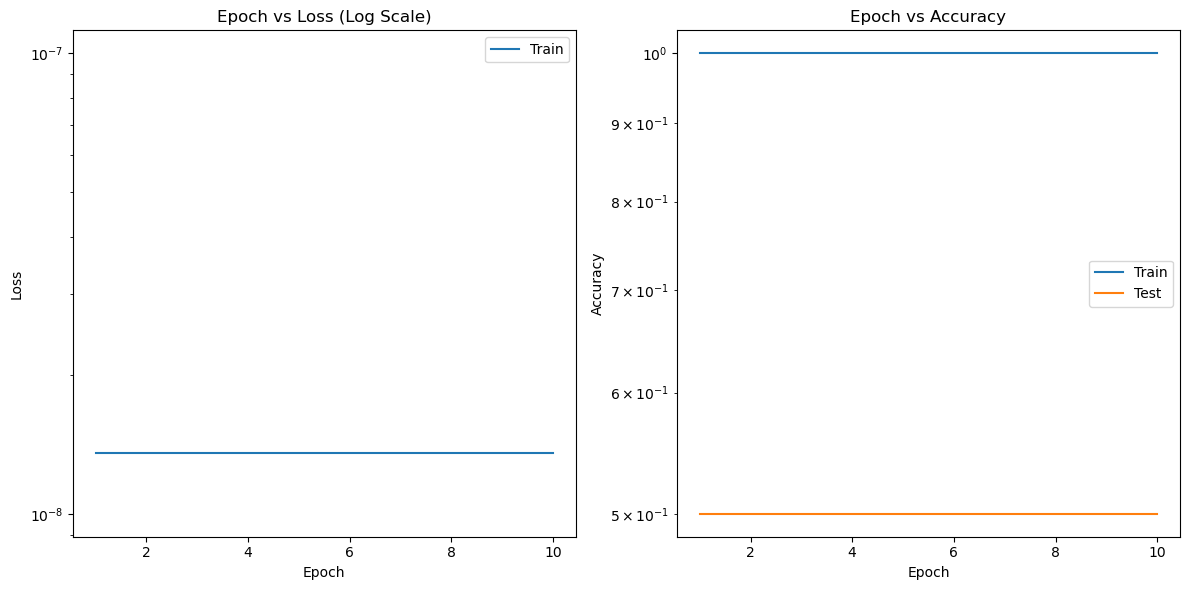

In [19]:
import matplotlib.pyplot as plt

# Lists to store data for plotting
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    # Your training and testing code here...
    # Make sure you calculate train_loss, test_loss, train_accuracy, and test_accuracy
    
    # Append values for plotting
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Plotting
plt.figure(figsize=(12, 6))

# Plotting losses
plt.subplot(1, 2, 1)
plt.semilogy(range(1, num_epochs + 1), train_losses, label='Train')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss (Log Scale)')
plt.legend()

# Plotting accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.yscale('log')  # Apply logarithmic scale only for y-axis
plt.legend()

plt.tight_layout()
plt.show()
